In [26]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$$\dot{\theta} = \omega$$
$$\dot{\omega} = \frac{(m+m_c)g\sin{\theta} - \cos{\theta}(u + ml\omega^2\sin{\theta})}{(4/3)(m+m_c)l - ml\cos{\theta}^2}$$
$$\dot{h} = dh$$
$$\dot{dh} = \frac{u + ml(\omega^2\sin{\theta} - \dot{\omega}\cos{\theta})}{m + m_c}$$

In [33]:
from pendulum import InvertedPendulumSystem
from simulator import Simulator
from buffer import IterationBuffer
from model import GaussianPDFModel
from optimizer import Optimizer
from policy_reinforce import PolicyREINFORCE
from monte_carlo import MonteCarloSimulationScenario
%autoreload 2

Text(0.5, 1.0, 'Angular velocity')

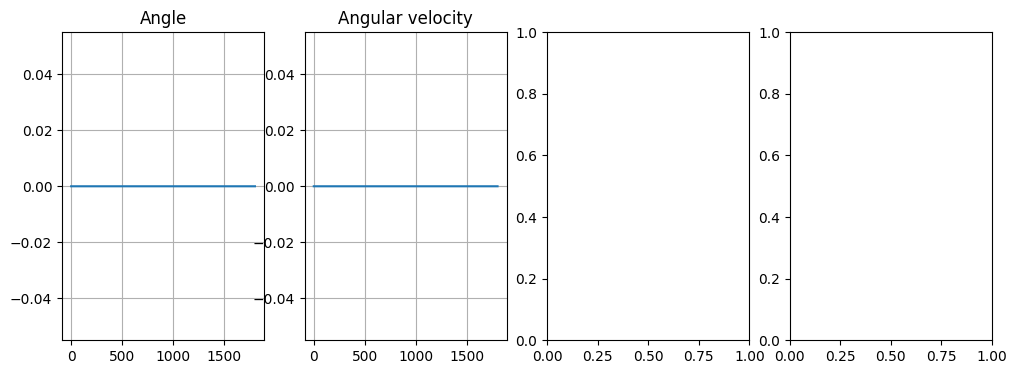

In [57]:
system = InvertedPendulumSystem()
simulator = Simulator(
    system, N_steps=1800, step_size=0.003, state_init=np.array([0.0,0.0])
)
simulator.reset()

observations = []
actions = []
while simulator.step():
    (
        observation,
        action,
        step_idx,
    ) = simulator.get_sim_step_data()

    new_action = np.array([-5 * observation[0] + -2 * observation[1]])

    system.receive_action(new_action)
    observations.append(np.copy(observation))
    actions.append(np.copy(new_action))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(12, 4)
ax1.plot(np.array(observations)[:, 0])
ax1.grid()
ax1.set_title("Angle")
ax2.plot(np.array(observations)[:, 1])
ax2.grid()
ax2.set_title("Angular velocity")
# ax3.plot(np.array(observations)[:, 2])
# ax3.grid()
# ax3.set_title("horizontal distance")
# ax3.plot(np.array(observations)[:, 2])
# ax3.grid()
# ax3.set_title("horizontal distance")
# ax4.plot(np.array(observations)[:, 3])
# ax4.grid()
# ax4.set_title("horizontal angular")

# Reinforce

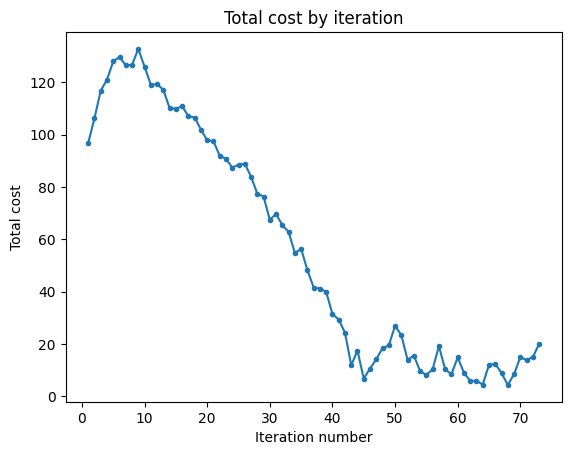

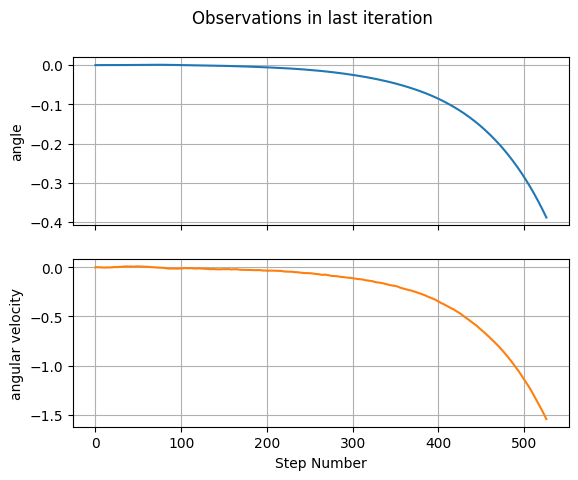

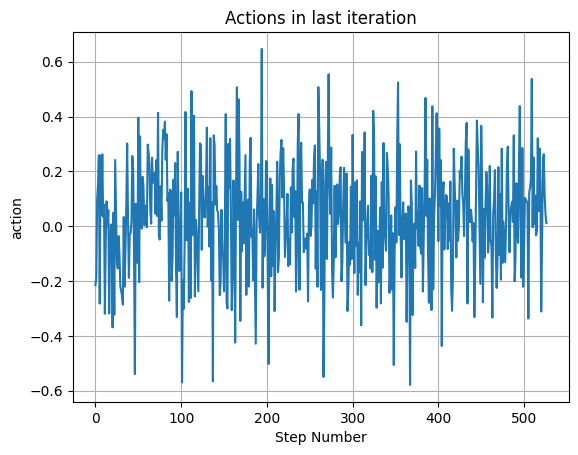

In [60]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = InvertedPendulumSystem()

simulator = Simulator(
    system, N_steps=1000, step_size=0.003, state_init=np.array([0.0, 0.0])
)
model = GaussianPDFModel(
    dim_observation=system.dim_observation,
    dim_action=system.dim_action,
    action_bounds=np.array([[-20, 20]]),
    scale_factor=10,  # TRY TO FIND scale_factor EMPIRICALLY
    dim_hidden=32, # TRY TO FIND dim_hidden EMPIRICALLY
    std=0.01, # TRY TO FIND STD EMPIRICALLY
    n_hidden_layers=3 # TRY TO FIND STD EMPIRICALLY
)

optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.001), # TRY TO FIND lr EMPIRICALLY
    #---------------------------------------------------------------------------
)
## Or if you want to use scheduler then initialize optimizer, via, for instance
# lr_scheduler_fading_coeff = 1
# optimizer = Optimizer(
#     model=model,
#     opt_method=torch.optim.Adam,
#     opt_options=dict(lr=1.0, betas=(0.8, 0.9)),
#     shuffle=False,
#     lr_scheduler_method=torch.optim.lr_scheduler.MultiplicativeLR,
#     lr_scheduler_options={
#         "lr_lambda": lambda iteration: 1
#         / np.sqrt((iteration / lr_scheduler_fading_coeff) ** 2 + 1)
#     },
#     lr_scheduler_switch=LRSchedulerSwitch(norm_observation_threshold=0.1),
# )
#
# BELEIVE US! YOU CAN SOLVE THIS TASK WITHOUT SCHEDULER

policy = PolicyREINFORCE(model, optimizer, is_with_baseline=True)


# This termination criterion never terminates episodes
trivial_termination_criterion = lambda *args: False

## EXAMPLE. This termination criterion terminates episode if observation norm >= 20

MAX_ANGLE = np.pi / 8
MAX_X = 5
termination_criterion = (
    lambda observation, action, running_objective, total_objective: (
        (np.abs(observation[0]) > MAX_ANGLE)# or (np.abs(observation[2]) > MAX_X)
    )
)


scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    N_episodes=5, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=100, # You can change the number of iterations if you want
    termination_criterion=termination_criterion,
    discount_factor=0.99,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()